# Integro Differential Equations
Looking at Schaum, Jerono (2019), we can use the provided PDE for modeling the growth population. This results in the following Equation: 
$$
\frac{\partial n(m,t)}{\partial t} = 
- \frac{\partial}{\partial m} \left[ r_g(m, S) \, n(m, t) \right] 
- \Gamma(m, S) \, n(m, t) 
+ 2 \int_m^{m_{\text{max}}} \Gamma(m', S) \, p(m' \to m) \, n(m', t) \, dm' 
- D \, n(m, t)
$$
$$
\dot{S}(t) = - \int_0^{m^+} r_{g}(m, S) \, n(m, t) \, dm
$$
Note that when solving numerically, i do not use the chain rule for the derivative with regards to $m$ (even though i probably should...). Simply because it is easier to implement numerically and i enforce the assumption that the growth rate is independent of the cell mass. This assumption might not be accurate, however it simplifies the equation and apparently reduces the computational effort.
Therefore we make the approximation : 
$$
\frac{\partial}{\partial m} \left[ r_g \, n \right] 
\approx \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
$$ 

Since $n=f(m,t)$ this numerically, we have to discretize the System over the mass-Domain with regards to $$\Delta m=m_{i}-m_{i-1}$$ and then solve it for small time increments $\Delta t$. Basically creating a System of ODEs for each incremental Distribution $n_{i}$

Now to make this look more "mathematical" i introduce :
$$
\begin{aligned}
& \Delta m = m_i - m_{i-1}  ,  i  \epsilon [0,M] \\
& n_i(t) \approx n(m_i, t) \\
& r_{g,i}(S) = r_g(m_i, S) \\
& \Gamma_i(S) = \Gamma(m_i, S) \\
& p_{k \to i} \approx p(m_k \to m_i)
\end{aligned}
$$
The integral term can be approximated by the sum over the increments,so that for each $n_{i}$ we can apply : 
$$
\frac{d n_i}{dt} = 
- \frac{(r_g \, n)_i - (r_g \, n)_{i-1}}{\Delta m}
- \Gamma_i(S) \, n_i
+ 2 \sum_{k=i}^{M} \Gamma_k(S) \, p_{k \to i} \, n_k \, \Delta m
- D \, n_i
$$
and also the additional condition for the Substrate :
$$
\frac{dS}{dt} = - \sum_{i=0}^{M} r_{g,i}(S) \, n_i \, \Delta m
$$

Now lets get to coding...



In [321]:
#imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random #for random starting values around a mean value 

In [322]:
#domain and discretization
M  =  100
m_min,  m_max   =    0.0,    2.0 
m = np.linspace(m_min, m_max, M+1)
delta_m = m[1] - m[0]

In [ ]:
#functions for growth rate/death rate...
def r_g (m_i, S):
    return 1* S  #assume independent of m_i (see above for reason)

def Gamma(m_i):
    return 0.5/(1+m_i**2) #assume linear dependence on m_i

def p(k, i):
    if k > i :      #cells division can never lead to bigger cell size than the parent cell
        return 0.0#1.0 / (k + 1)        #the +1 is to avoid division by zero
    return 0.0

In [324]:
def population_system (t,y):
    n=y[:-1]
    S=y[-1]
    
    dn_dt= np.zeros_like(n)
    r_g_values = r_g(m,S)
    Gamma_values=Gamma(m)
    
    # Compute the finite difference approximation for ∂/∂m (r_g * n)
    rg_n = r_g_values * n
    d_rg_n_dm = np.zeros_like(n)
    d_rg_n_dm[1:] = (rg_n[1:] - rg_n[:-1]) / delta_m
    d_rg_n_dm[0] = 0.0  # boundary condition or zero flux assumption


    # Now compute the RHS for each n_i
    for i in range(M+1):
        # Fragmentation sum
        frag_sum = 0.0
        for k in range(i, M+1):
            frag_sum += Gamma_values[k] * p(k, i) * n[k]
        frag_sum *= 2 * delta_m

        dn_dt[i] = -d_rg_n_dm[i] - Gamma_values[i] * n[i] + frag_sum #- D * n[i]

    # Substrate equation
    dS_dt = -np.sum(r_g_values * n) * delta_m

    return np.concatenate([dn_dt, [dS_dt]])



[0.9698991947346565, 1.0693807347872961, 0.8959641322169627, 0.982604709693397, 1.065766355208702, 0.9339017065215549, 1.0017725955903207, 0.9938094865412103, 1.0005777337549242, 1.0139192491069438, 0.9954109601031569, 0.9433719851351934, 1.0350610599509127, 0.9156445198675965, 0.9858239270188229, 1.124368385802661, 1.01696027336153, 0.9814979255317106, 1.0381375618197506, 0.9015952251000933, 0.9809160565440863, 1.0376356508947626, 1.0491938410764297, 0.9698303969977672, 1.0166161058595233, 1.0218646378856173, 1.00951972038767, 1.0104456962049586, 0.9947980872341046, 1.0518102069778363, 1.039499775809151, 0.9827797353299503, 0.9678170555383928, 0.9348359801734254, 1.0249296663533187, 0.9833351736604738, 0.9688428342010589, 0.9857684251898902, 1.0602095036154526, 1.0119003698145541, 0.9671203483666625, 0.945709619864758, 0.9620116896123303, 1.0008832329661752, 0.9988471151550667, 1.0988944325672316, 0.9888845461532011, 1.079592130788731, 1.0043495084952963, 1.0549589619644306, 1.0214680

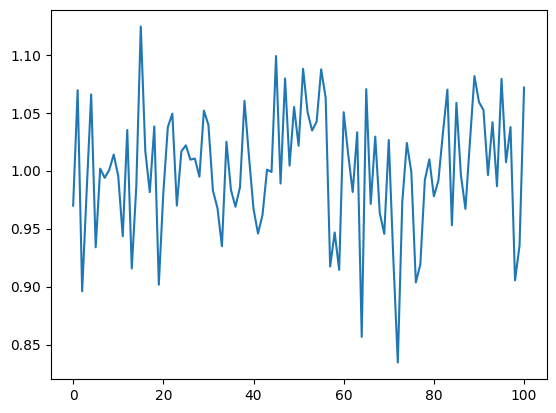

In [325]:
# Initial population n_i

n0 = [random.gauss(1.0, 0.05) for i in range(len(m))] #mean 1 , sigma=0.1
plt.plot(n0)
print(n0)
                 # Normalize

# Initial substrate S
S0 = 10.0

# Combine into single initial condition vector
y0 = np.concatenate([n0, [S0]])

In [326]:
t_span = (0.0, 10.0)
t_eval = np.linspace(*t_span, 200)

sol = solve_ivp(population_system, t_span, y0, t_eval=t_eval, method='RK45')

Gamma called with m_i =  [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.  ]
Gamma called with m_i =  [0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1

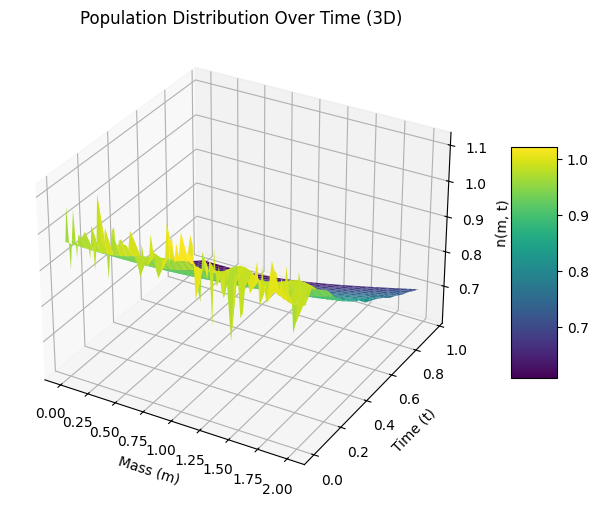

In [327]:
from mpl_toolkits.mplot3d import Axes3D

j=20
# Create a meshgrid for mass (m) and time (t)
M, T = np.meshgrid(m, sol.t[:j])  

# Extract corresponding n(m, t) values for the first 4 time points
N = sol.y[:-1, :j].T  # Transpose to match dimensions

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(M, T, N, cmap='viridis')

ax.set_xlabel('Mass (m)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('n(m, t)')
ax.set_title('Population Distribution Over Time (3D)')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

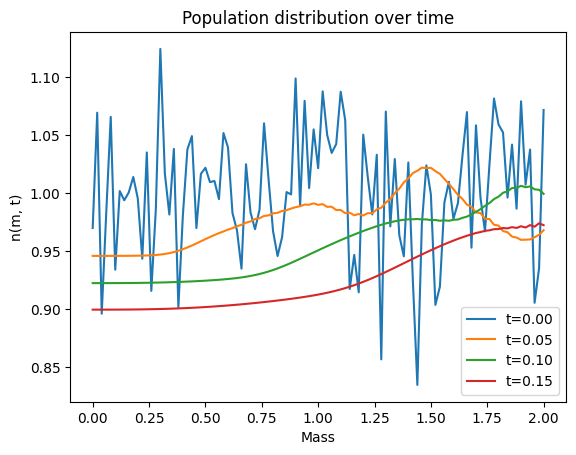

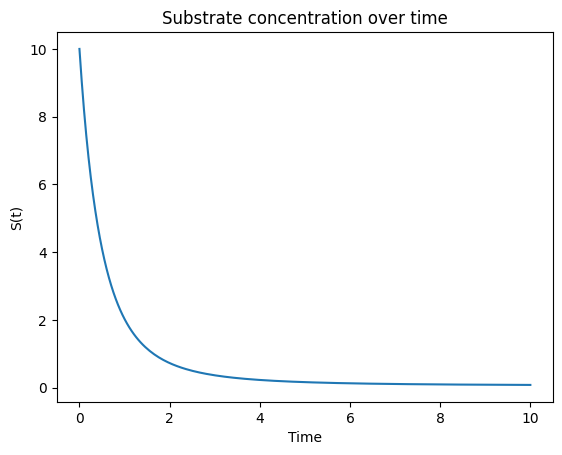

In [328]:


# Plot population distribution at different time steps
for idx in range(0,4):
    plt.plot(m, sol.y[:-1, idx], label=f't={sol.t[idx]:.2f}')
plt.xlabel('Mass')
plt.ylabel('n(m, t)')
plt.title('Population distribution over time')
plt.legend()
plt.show()

# Plot substrate over time
plt.plot(sol.t, sol.y[-1, :])
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('Substrate concentration over time')
plt.show()
